# First steps

## Module installation
Let's first install required python modules.

In [12]:
###########################
##   IMGPROC MODULES
###########################
%pip install pillow

###########################
##   ML MODULES
###########################
%pip install torch torchvision torchmetrics torchsummary scikit-learn tqdm
%pip install wandb -qqq

###########################
##   OTHER MODULES
###########################
%pip install shortuuid
%pip install gdown # gDrive
%pip install matplotlib

###########################
##   LOGGING
###########################
import logging
import logging.config

# Create the Logger
logging.basicConfig(format="%(asctime)-15s %(levelname)s - %(message)s",datefmt='%Y-%m-%d %H:%M:%S')
logger= logging.getLogger("gmnist-classifier")
logger.setLevel(logging.INFO)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


### Project folders

In [13]:
import os
from pathlib import Path

def create_dir(dirname):
    logger.info("Creating directory %s ..." % (dirname))
    path = Path(dirname)
    path.mkdir(parents=True, exist_ok=True)
    logger.info("Run directory %s created successfully ..." % (dirname))

# - Set project directory
topdir= os.getcwd()
logger.info("topdir=%s" % (topdir))

############################
##   DATASET URL
############################
dataset_name= "galaxy_mnist-dataset"
dataset_dir= os.path.join(topdir, dataset_name)
dataset_filename= 'galaxy_mnist-dataset.tar.gz'
dataset_url= 'https://drive.google.com/uc?export=download&id=1OprJ_NQIFyQSRWqjGLFQsAMumHvJ-tMB'
filename_train= os.path.join(dataset_dir, "train/1chan/datalist_train.json")
filename_test= os.path.join(dataset_dir, "test/1chan/datalist_test.json")
filename_train_3chan= os.path.join(dataset_dir, "train/3chan/datalist_train.json")
filename_test_3chan= os.path.join(dataset_dir, "test/3chan/datalist_test.json")

2025-03-08 10:40:38 INFO - topdir=/home/riggi/Analysis/MLProjects/usc8-ai-workshop


# Dataset
For this tutorial, we are going to use the Galaxy MNIST dataset [https://github.com/mwalmsley/galaxy_mnist]. We have slighly modified the format for this tutorial. The modified dataset is available for download in Google Drive.

The dataset currently contains 10,000 images of galaxies in three optical bands, either low3x64x64 (low reso) or 3x224x224 (high reso), taken from the Galaxy Zoo project. The dataset is split into two subsets: 

- train: 8000 images
- test: 2000 images

The dataset contains 4 possible classes of galaxy morphologies:

- SMOOTH_ROUND: smooth and round galaxy. Should not have signs of spires.   
- SMOOTH_CIGAR: smooth and cigar-shaped galaxy, looks like being seen edge on. This should not have signs of spires of a spiral galaxy.
- EDGE_ON_DISK: edge-on-disk/spiral galaxy. This disk galaxy should have signs of spires, as seen from an edge-on perspective.
- UNBARRED_SPIRAL: unbarred spiral galaxy. Has signs of a disk and/or spires

Note that categories SMOOTH_CIGAR and EDGE_ON_DISK classes tend to be very similar to each other. To categorize them, ask yourself the following question: Is this galaxy very smooth, maybe with a small bulge? Then it belongs to class SMOOTH_CIGAR. Does it have irregularities/signs of structure? Then it belongs to class EDGE_ON_DISK.

## Dataset Download
We download the dataset from GoogleDrive and unzip it in the main folder.

In [3]:
import os
import gdown
import tarfile

#################################
##      DOWNLOAD FILES
#################################
def download_files_from_gdrive(url, outfile, force=False):
  """ Download model file from gDrive """

  if force or not os.path.isfile(outfile):
    gdown.download(url, outfile, quiet=False)
   
def untar_file(filename):
  """ Unzip file """
  
  fp= tarfile.open(filename)
  fp.extractall('.')
  fp.close()  

# - Enter top directory
os.chdir(topdir)

# - Download dataset
logger.info("Downloading file from url %s ..." % (dataset_url))
download_files_from_gdrive(dataset_url, dataset_filename, force=False)
logger.info("DONE!")

# - Untar dataset
logger.info("Unzipping dataset file %s ..." % (dataset_filename))
untar_file(dataset_filename)
logger.info("DONE")

2025-03-07 21:05:55 INFO - Downloading file from url https://drive.google.com/uc?export=download&id=1OprJ_NQIFyQSRWqjGLFQsAMumHvJ-tMB ...
2025-03-07 21:05:55 INFO - DONE!
2025-03-07 21:05:55 INFO - Unzipping dataset file galaxy_mnist-dataset.tar.gz ...
2025-03-07 21:06:00 INFO - DONE


## Create PyTorch Dataset
Let's create a custom pytorch dataset using base VisionDataset. 

In [24]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import Subset, random_split
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
import PIL
from PIL import Image
import json
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from itertools import islice
import random
import matplotlib.pyplot as plt

#################################
##      DATASET
#################################
class GMNISTDataset(Dataset):
  """ Galaxy MNIST dataset """

  def __init__(
      self, 
      metadata_file: Optional[Union[str, Path]] = "",
      subset: Optional[Subset] = None,
      transform: Optional[Callable] = None,
      target_transform: Optional[Callable] = None,
  ):
    """
      Arguments:
        metadata_file (string): Path to the json file with annotations.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    
    self.subset= subset
    if self.subset is None:
        logger.info("Reading dataset metadata from file %s ..." % (metadata_file))
        self.__read_metadata(metadata_file)
        
    self.transform = transform
    self.target_transform = target_transform
    self.pil2tensor = T.Compose([T.PILToTensor()]) # no normalization
    #self.pil2tensor = T.Compose([T.ToTensor()]) # normalize in [0,1] assuming max=255
    
    self.target2label= {
      0: "smooth_round",  
      1: "smooth_cigar",
      2: "edge_on_disk",
      3: "unbarred_spiral"
    }

  def __read_metadata(self, filename):
    """ Read json metadata """
    
    f= open(filename, "r")
    self.datalist= json.load(f)["data"]
  
  def __len__(self):
    """ Return size of dataset """ 
    if self.subset:
      return len(self.subset) 
    else:
      return len(self.datalist)
   
  def __load_item(self, idx):
    """ Load dataset item """
    
    # - Read image path & class id
    img_path= self.datalist[idx]['filepaths'][0]
    target= self.datalist[idx]['id'] # class id
    
    # - Read PIL image as RGB
    #logger.info("Read PIL image ...")
    img = Image.open(img_path).convert("RGB")
    
    return img, target
    
  def __load_subset_item(self, idx):
    """ Load dataset subset item """
    
    # - Get item from subset
    #   NB: img is a tensor
    #logger.info("Read subset item ...")
    return self.subset[idx]

    
  def __getitem__(self, idx):
    """ Return dataset item """
    
    # - Load image/label
    if self.subset is None:
      img, target= self.__load_item(idx)
    else:
      img, target= self.subset[idx]

    # - Convert PIL to tensor?
    if isinstance(img, PIL.Image.Image):
      img= self.pil2tensor(img)
    
    # - Transform img/tensor?
    if self.transform is not None:
      #logger.info("__getitem__: Transform image ...")
      img = self.transform(img)

    # - Transform target?
    if self.target_transform is not None:
      target = self.target_transform(target)
       
    return img, target

## Create data custom transforms

### Random flip
A transform that flip either image horizontally/vertically or leave image unchanged.

In [14]:
class Flip(torch.nn.Module):
  """ Flip image """

  def __init__(self):
    super().__init__()

  def forward(self, img):
    op= random.choice([1,2,3])
    if op==1:
      return TF.hflip(img)
    elif op==2:
      return TF.vflip(img)
    else:
      return img

### Random rotate
A transform that randomly rotate image by 90 degrees step.

In [15]:
class Rotate90(torch.nn.Module):
  """Rotate by one of the given angles: 90, 270, """

  def __init__(self):
    super().__init__()

  def forward(self, img):
    op= random.choice([1,2,3,4])
    if op==1:
      return TF.rotate(img, 90)
    elif op==2:
      return TF.rotate(img, 180)
    elif op==3:
      return TF.rotate(img, 270)
    elif op==4:
      return img

### Sanitization
A transform that set NaNs/inf pixels to 0.

In [16]:
class Sanitization(torch.nn.Module):
  """ Set NaN/inf pixels to 0 """

  def __init__(self):
    super().__init__()
   
  def forward(self, img):
    # - Create mask of non-nans pixels    
    cond= np.isfinite(img).bool()  
    
    # - Set nans to 0
    img[~cond]= 0
    
    return img

### MinMax Normalization
A transform that normalize each image channel separately to desired range (e.g. [0,1]). Please note that torch
ToTensor() transform do [0,1] normalization but it assumes a data maximum of 255. Many image channels in 
GMNIST dataset have a smaller maximum. This transform treats each channels independently, equalizing channel range. 
This means ignoring a given flux ratio between bands as a potential image classification feature.

In [18]:
class MinMaxNormalization(torch.nn.Module):
  """ Normalize each tensor in batch in min/max range """

  def __init__(self, norm_min=0., norm_max=1., exclude_zeros=True, set_nans_to_min=False):
    super().__init__()
    self.norm_min= norm_min
    self.norm_max= norm_max
    self.exclude_zeros= exclude_zeros
    self.set_nans_to_min= set_nans_to_min
    
  def forward(self, img):
    # - Compute data min/max of each image in batch across ny,nx channels
    ndim= img.ndim
    if ndim==4: # [BATCH,CHAN,Ny,Nx]
      img_min= torch.amin(img, dim=(2,3), keepdim=True)
      img_max= torch.amax(img, dim=(2,3), keepdim=True)
    elif ndim==3: # [CHAN,Ny,Nx]
      img_min= torch.amin(img, dim=(1,2), keepdim=True)
      img_max= torch.amax(img, dim=(1,2), keepdim=True)
    else:
      logger.warn("Unexpected ndim (%d), returning same image ..." % (ndim))
      return img
        
    # - Create mask of non-nans/empty pixels
    if self.exclude_zeros:
      cond= np.logical_and(img!=0, np.isfinite(img)).bool()
    else:
      cond= np.isfinite(img).bool()

    # - Normalize image in range
    img_norm= (img-img_min)/(img_max-img_min) * (self.norm_max-self.norm_min) + self.norm_min

    # - Set nans to 0
    if self.set_nans_to_min:
      img_norm[~cond]= self.norm_min
    else:
      img_norm[~cond]= 0 
    
    return img_norm

### Absolute Channel Maximum Scaling
This transform finds, for each image, the absolute maximum, and then it scales all channels by this value, taking into account any possible band flux ratio information as sensitive classification variable.

In [20]:
class AbsChanMaxScaling(torch.nn.Module):
  """ Scale tensor by absolute channel maximum """

  def __init__(self):    
    super().__init__()
   
  def forward(self, img):
    
    # - Compute absolute image max across channels
    ndim= img.ndim
    if ndim==4: # [BATCH,CHAN,Ny,Nx]
      img_absmax= torch.amax(img, dim=(1,2,3), keepdim=True)
    elif ndim==3: # [CHAN,Ny,Nx]
      img_absmax= torch.amax(img, dim=(0,1,2), keepdim=True)
    else:
      logger.warn("Unexpected ndim (%d), returning same image ..." % (ndim))
      return img
    
    # - Scale image by absmax
    img_scaled= img/img_absmax
    
    return img_scaled

### Define composite transforms
Let's define two transforms: one for training data, having standard plus additional augmenter transforms, and the other for validation/test data, having standard transforms.

Standard transforms are:

- Sanitization
- Image resize
- Intra-channel normalization
- Image sample normalization (optional)

Augmenter transforms are:

- Random flipping
- Random rotation 90 deg
- Random crop and resize

In [21]:
# - Define dataset transforms
logger.info("Define dataset transforms ...")
img_resize= 224

transform_train= T.Compose(
  [  
    Sanitization(),  
    T.Resize(img_resize, interpolation=T.InterpolationMode.BICUBIC),
    Flip(),
	Rotate90(),
    T.RandomResizedCrop(img_resize, scale=(0.5, 1.0), ratio=(1., 1.), interpolation=T.InterpolationMode.BICUBIC),
    AbsChanMaxScaling(),  
    #T.Normalize(mean=(0.5, 0.5, 0.5), std=(1, 1, 1), max_pixel_value=255.0)  # Normalize to [0,1]
    #T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0)  # Normalize to [-1,1]
    #T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)  
    #T.ToTensor(),# convert to tensor in range [0,1]
  ]
)

transform= T.Compose(
  [
    Sanitization(),  
    T.Resize(img_resize, interpolation=T.InterpolationMode.BICUBIC),
    AbsChanMaxScaling(),
    #T.Normalize(mean=(0.5, 0.5, 0.5), std=(1, 1, 1), max_pixel_value=255.0)  # Normalize to [0,1]
    #T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0)  # Normalize to [-1,1]
    #T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)  
    #T.ToTensor(),# convert to tensor in range [0,1]
  ]
)

2025-03-08 11:03:46 INFO - Define dataset transforms ...


## Create datasets
Load GMNIST train/test dataset using the GMNISTDataset class created above. Then, split the train dataset into two subsets, one to be used as training set (70% of the original train sample) and the other as validation set (the remaining 30%).

In [22]:
# - Read traincv dataset
logger.info("Read train-cv dataset from file %s ..." % (filename_train_3chan))
dataset_traincv= GMNISTDataset(
  metadata_file=filename_train_3chan,
)

# - Read test dataset
logger.info("Read test dataset from file %s ..." % (filename_test_3chan))
dataset_test= GMNISTDataset(
  metadata_file=filename_test_3chan,
  transform=transform
)

# - Split train-cv dataset into train & validation samples
logger.info("Splitting train-cv dataset in 70% train/30% val subsets...")
generator= torch.Generator().manual_seed(42)
subset_train, subset_val= random_split(dataset_traincv, [0.7, 0.3], generator=generator)

# - Create train & val datasets from subsets
logger.info("Creating train & val datasets from subsets ...")
dataset_train= GMNISTDataset(subset=subset_train, transform=transform_train)
dataset_val= GMNISTDataset(subset=subset_val, transform=transform)

logger.info("#%d entries in train set ..." % (len(dataset_train)))
logger.info("#%d entries in validation set ..." % (len(dataset_val)))
logger.info("#%d entries in test set ..." % (len(dataset_test)))

2025-03-08 11:05:50 INFO - Read train-cv dataset from file /home/riggi/Analysis/MLProjects/usc8-ai-workshop/galaxy_mnist-dataset/train/3chan/datalist_train.json ...
2025-03-08 11:05:50 INFO - Reading dataset metadata from file /home/riggi/Analysis/MLProjects/usc8-ai-workshop/galaxy_mnist-dataset/train/3chan/datalist_train.json ...
2025-03-08 11:05:50 INFO - Read test dataset from file /home/riggi/Analysis/MLProjects/usc8-ai-workshop/galaxy_mnist-dataset/test/3chan/datalist_test.json ...
2025-03-08 11:05:50 INFO - Reading dataset metadata from file /home/riggi/Analysis/MLProjects/usc8-ai-workshop/galaxy_mnist-dataset/test/3chan/datalist_test.json ...
2025-03-08 11:05:50 INFO - Splitting train-cv dataset in 70% train/30% val subsets...
2025-03-08 11:05:50 INFO - Creating train & val datasets from subsets ...
2025-03-08 11:05:50 INFO - #5600 entries in train set ...
2025-03-08 11:05:50 INFO - #2400 entries in validation set ...
2025-03-08 11:05:50 INFO - #2000 entries in test set ...


### Draw sample images
Let's draw some sample images from the train set.

/tmp/ipykernel_1425898/3453250542.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond= np.isfinite(img).bool()


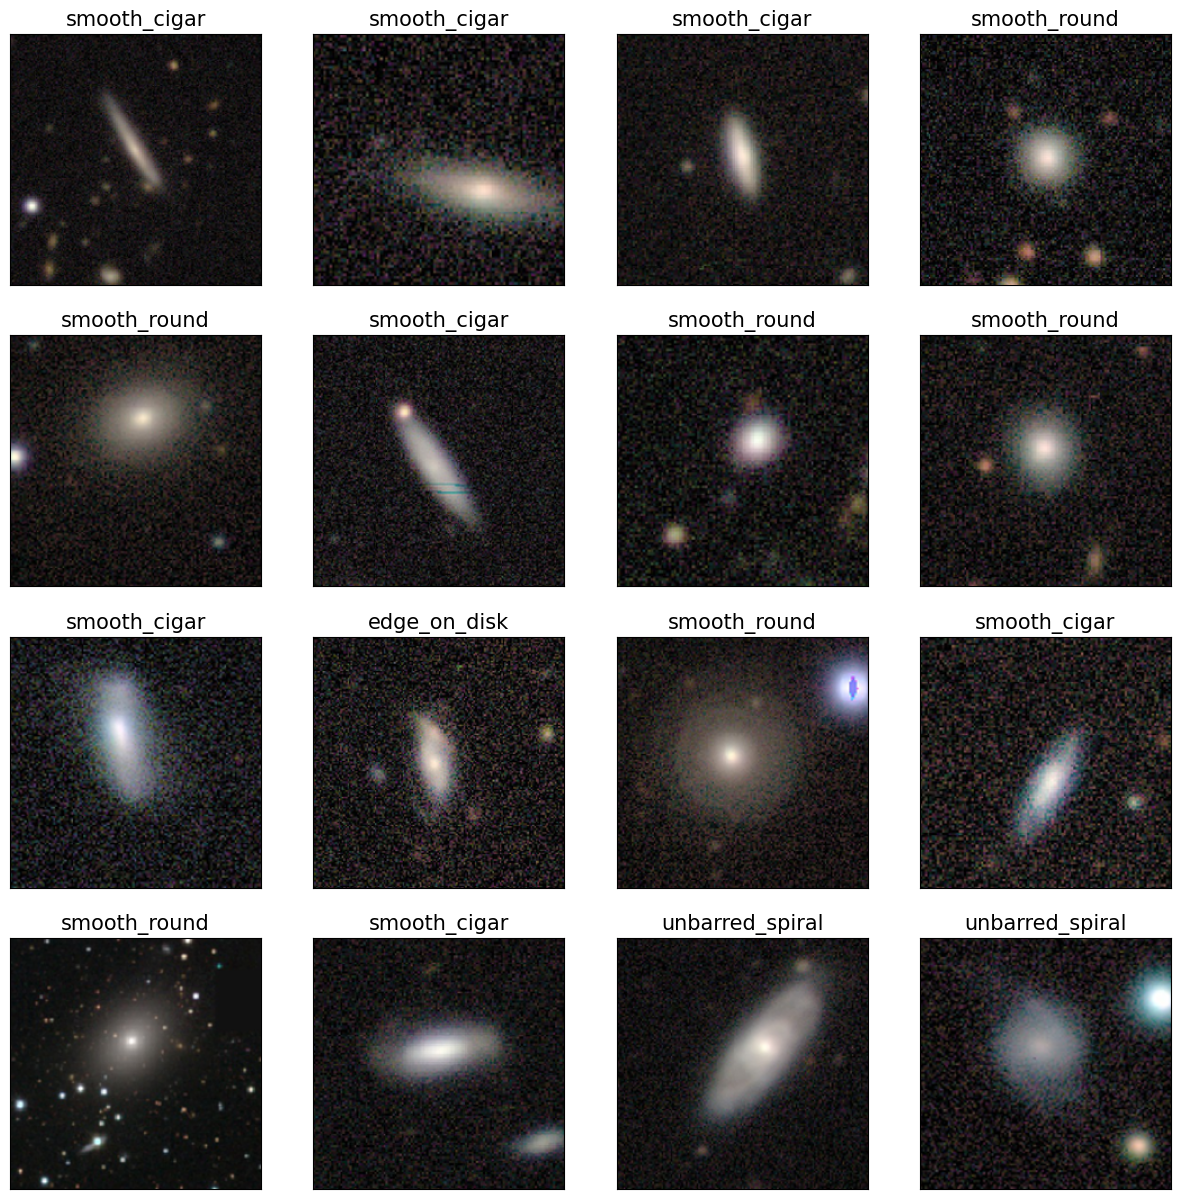

In [23]:
# - Plot images
fig = plt.figure(figsize=(15, 15))
for i, (tensor_image, target) in islice(enumerate(dataset_train), 16):
  label= dataset_train.target2label[target]  
  ax = fig.add_subplot(4, 4, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  im= ax.imshow(tensor_image.permute(1, 2, 0))
  ax.set_title(f'{label}', size=15)
  
plt.show()

# CNN classifier
Let's now define a custom configurable CNN architecture to perform GMNIST image classification.

## Classifier class
Let's implement a class that uses the torch sequential class to define the architecture of the net. 

In [86]:
import wandb
import torch
import torchvision
import torchmetrics
from torchsummary import summary
from tqdm import tqdm

class AverageMeter:
  def __init__(self):
    self.reset()

  def reset(self):
    self.sum = 0
    self.count = 0

  def update(self, value, n=1):
    self.sum += value * n
    self.count += n

  @property
  def avg(self):
    return self.sum / self.count if self.count > 0 else 0

###############################
##   CLASSIFIER
###############################
#class GMNISTClassifier(nn.Module):
class GMNISTClassifier():
  """ Build a custom CNN network """  

  def __init__(
      self,
      nn_arch: Optional[str] = "custom",
      num_classes: Optional[int] = 4,
      n_conv_layers: Optional[int] = 3,
      n_filters: Optional[Union[int, list]] = [8,16,32],
      kern_sizes: Optional[Union[int, list]] = [3,5,5],
      strides: Optional[Union[int, list]] = [1,1,1],
      add_maxpool: Optional[bool] = True,
      pool_sizes: Optional[Union[int, list]] = 2,
      add_batchnorm: Optional[bool] = True,
      n_dense_layers: Optional[int] = 1,
      dense_layer_sizes: Optional[Union[int, list]] = [64],
      add_dropout: Optional[bool] = True,
      dropout_prob: Optional[float] = 0.5
  ):
    #super(GMNISTClassifier, self).__init__()
    self.model= None
    self.device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.nn_arch= nn_arch
    self.num_classes= num_classes
    self.n_conv_layers= n_conv_layers
    self.n_dense_layers= n_dense_layers
    self.add_maxpool= add_maxpool
    self.add_batchnorm= add_batchnorm
    self.add_dropout= add_dropout
    self.dropout_prob= dropout_prob
    
    # - Set number of conv filters per layer
    if isinstance(n_filters, list):
      if len(n_filters)!=self.n_conv_layers:
        raise Exception("n_filters list must have length equal to n_conv_layers!")  
      else:
        self.n_filters= n_filters
    else:
      self.n_filters= [n_filters]*self.n_conv_layers 
    
    # - Set conv filter kernel size per layer
    if isinstance(kern_sizes, list):
      if len(kern_sizes)!=self.n_conv_layers:
        raise Exception("kern_sizes list must have length equal to n_conv_layers!")  
      else:
        self.kern_sizes= kern_sizes
    else:
      self.kern_sizes= [kern_sizes]*self.n_conv_layers
    
    # - Set conv filter stride size per layer
    if isinstance(strides, list):
      if len(strides)!=self.n_conv_layers:
        raise Exception("strides list must have length equal to n_conv_layers!")  
      else:
        self.strides= strides
    else:
      self.strides= [strides]*self.n_conv_layers
    
    # - Set conv filter stride size per layer
    if isinstance(pool_sizes, list):
      if len(pool_sizes)!=self.n_conv_layers:
        raise Exception("pool_sizes list must have length equal to n_conv_layers!")  
      else:
        self.pool_sizes= pool_sizes
    else:
      self.pool_sizes= [pool_sizes]*self.n_conv_layers
    
    # - Set dense layer size per layer
    if isinstance(dense_layer_sizes, list):
      if len(dense_layer_sizes)!=self.n_dense_layers:
        raise Exception("pool_sizes list must have length equal to n_conv_layers!")  
      else:
        self.dense_layer_sizes= dense_layer_sizes
    else:
      self.dense_layer_sizes= [dense_layer_sizes]*self.n_dense_layers
    
    # - Build network
    logger.info("Building NN architecture ...")
    if self.__build_net()<0:
      logger.error("Failed to build nn!")
      raise Exception("Failed to build nn!")
    
    # - Move model to device
    logger.info("Moving model to device %s ..." % (self.device))
    self.model.to(self.device)
    

  def __build_net(self):
    """ Create network from pre-defined architecture (e.g. resnet) """
    
    if self.nn_arch=="custom":
      logger.info("Initializing network with custom architecture ...")
      return self.__build_custom_net()
    else:
      logger.info("Initializing network with %s architecture ..." % (self.nn_arch))
      return self.__build_predefined_net()

  def __build_predefined_net(self):
    """ Create network from pre-defined architecture (e.g. resnet) """
    
    # - Load predefined arch
    if self.nn_arch=="resnet18":
      self.model = torchvision.models.resnet18(weights='IMAGENET1K_V2') # IMAGENET1K_V1
    elif self.nn_arch=="resnet34":
      self.model = torchvision.models.resnet34(weights='IMAGENET1K_V2')  
    elif self.nn_arch=="resnet50":
      self.model = torchvision.models.resnet50(weights='IMAGENET1K_V2')
    elif self.nn_arch=="resnet101":
      self.model = torchvision.models.resnet101(weights='IMAGENET1K_V2')  
    else:
      logger.error("Unsupported nn arch (%s) specified, see torch supported arch below and add it yourself!")
      print(torchvision.models.list_models(module=torchvision.models)) 
      return -1

    # - Oveeride head
    self.model.fc = nn.LazyLinear(self.num_classes)
    
    return 0
    
    
  def __build_custom_net(self):  
    """ Create network """
    
    # - Create model using nn.Sequential class
    self.model = torch.nn.Sequential()
    
    # - Add CNN layers
    for i in range(self.n_conv_layers):
      # - Add convolution layer  
      layer_name= 'conv' + str(i+1)
      #in_channels= 3 if i==0 else self.n_conv_filters[i-1]
      
      self.model.add_module(
        layer_name,
        torch.nn.LazyConv2d(
          #in_channels=in_channels, 
          out_channels=self.n_filters[i],
          kernel_size=self.kern_sizes[i],
          padding="same",
          stride=self.strides[i]
        )
      )
    
      # - Add activation
      layer_name= 'relu' + str(i+1)
      self.model.add_module(layer_name, torch.nn.ReLU())
      
      # - Add batch normalization?
      if self.add_batchnorm:
        layer_name= "bn" + str(i+1)
        self.model.add_module(layer_name, torch.nn.LazyBatchNorm2d())
    
      # - Add max pool layer?
      if self.add_maxpool:
        layer_name= 'pool' + str(i+1)
        self.model.add_module(layer_name, torch.nn.MaxPool2d(kernel_size=self.pool_sizes[i]))
        
    # - Flatten layer
    self.model.add_module('flatten', torch.nn.Flatten())
    
    # - Add dense layers
    for i in range(self.n_dense_layers):
      # - Add dense layer
      layer_name= "fc" + str(i+1)
      self.model.add_module(layer_name, torch.nn.LazyLinear(self.dense_layer_sizes[i]))
    
      # - Add activation
      layer_name= "relu_fc" + str(i+1)  
      self.model.add_module(layer_name, torch.nn.ReLU())
    
      # - Add dropout?
      if self.add_dropout:
        layer_name= "dropout" + str(i+1)  
        self.model.add_module(layer_name, torch.nn.Dropout(p=self.dropout_prob))
    
    # - Add dropout if no dense layer specified?
    if self.n_dense_layers<=0 and self.add_dropout:
      model.add_module("dropout", torch.nn.Dropout(p=self.dropout_prob))  
    
    # - Add output layer
    self.model.add_module("output", torch.nn.LazyLinear(self.num_classes))
    
    return 0
    
  def print_model_arch(self, input_shape):
    """ Print model arch summary """
    summary(self.model, input_shape)

  def __train_epoch(
    self,
    dataloader, 
    criterion, 
    optimizer, 
    epoch, 
    accuracy_metric,
    f1score_metric
  ):
    """ Train one epoch """
    
    # - Init metrics
    self.model.train()
    loss_meter = AverageMeter()
    accuracy_metric.reset()
    f1score_metric.reset()
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Training]", leave=False)

    # - Run batch loop
    for X_batch, y_batch in progress_bar:
      X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

      # - Compute prediction and loss   
      outputs = self.model(X_batch)
      loss = criterion(outputs, y_batch)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      # - Update loss and accuracy
      loss_meter.update(loss.item(), X_batch.size(0))
      preds = outputs.argmax(dim=1)
      accuracy_metric.update(preds, y_batch)
      f1score_metric.update(preds, y_batch)

      # - Update progress bar
      progress_bar.set_postfix(
        loss=loss_meter.avg, 
        accuracy=accuracy_metric.compute().item(),
        f1score=f1score_metric.compute().item()
      )

    avg_loss = loss_meter.avg
    avg_accuracy = accuracy_metric.compute().item()
    avg_f1score = f1score_metric.compute().item()

    return avg_loss, avg_accuracy, avg_f1score

  def __validate_epoch(
    self,
    dataloader,
    criterion,
    epoch,
    accuracy_metric,
    f1score_metric  
  ):
    """ Run validation loop """      
    
    # - Init metrics
    self.model.eval()
    loss_meter = AverageMeter()
    accuracy_metric.reset()
    f1score_metric.reset()
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Validation]", leave=False)
    
    with torch.no_grad():
      for X_batch, y_batch in progress_bar:
        X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

        # - Compute prediction and loss   
        outputs = self.model(X_batch)
        loss = criterion(outputs, y_batch)

        # - Update loss and accuracy
        loss_meter.update(loss.item(), X_batch.size(0))
        preds = outputs.argmax(dim=1)
        accuracy_metric.update(preds, y_batch)
        f1score_metric.update(preds, y_batch)

        # - Update progress bar
        progress_bar.set_postfix(
          loss=loss_meter.avg
        )
        
    avg_loss = loss_meter.avg
    avg_accuracy = accuracy_metric.compute().item()
    avg_f1score = f1score_metric.compute().item()
    
    return avg_loss, avg_accuracy, avg_f1score
    
    
  def run_train(
    self,
    train_dl,
    val_dl= None,
    num_epochs: Optional[int] = 1, 
    lr: Optional[float] = 1e-4,
    log_to_wandb=False  
  ):
    """ Train network """

    # - Check model was created
    if self.model is None:
      logger.error("Model was not initialized!")
      return -1

    # - Set loss
    logger.info("Defining loss & optimizer ...")
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
    
    # - Init metrics
    train_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes).to(self.device)
    train_f1score_metric = torchmetrics.F1Score(task="multiclass", num_classes=self.num_classes, average="macro").to(self.device)
    val_accuracy = None
    val_f1score = None
    if val_dl is not None:
      val_accuracy_metric= torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes).to(self.device)
      val_f1score_metric= torchmetrics.F1Score(task="multiclass", num_classes=self.num_classes, average="macro").to(self.device)

    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    f1score_hist_train = [0] * num_epochs
    loss_hist_val = [0] * num_epochs
    accuracy_hist_val = [0] * num_epochs
    f1score_hist_val = [0] * num_epochs 
        
    # - Training loop
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
      # - Run train batch loop
      train_loss, train_acc, train_f1score = self.__train_epoch(
        train_dl, 
        loss_fn, 
        optimizer,
        epoch, 
        train_accuracy_metric,
        train_f1score_metric  
      )
      loss_hist_train[epoch]= train_loss
      accuracy_hist_train[epoch]= train_acc
      f1score_hist_train[epoch]= train_f1score
        
      # - Run validation batch loop?
      val_loss= 0.
      val_acc= 0.
      val_f1score= 0.
        
      if val_dl is not None:
        val_loss, val_acc, val_f1score = self.__validate_epoch(
          val_dl, 
          loss_fn,
          epoch, 
          val_accuracy_metric,
          val_f1score_metric  
        )
        loss_hist_val[epoch]= val_loss
        accuracy_hist_val[epoch]= val_acc
        f1score_hist_val[epoch]= val_f1score

      # - Log metrics to wandb 
      if log_to_wandb:
        wandb.log(
          {
            "loss": train_loss,  
            "acc": train_acc,
            "f1score": train_f1score,  
            "loss_val": val_loss,  
            "acc_val": val_acc,
            "f1score_val": val_f1score, 
          }
        )
        
      # - Print metrics  
      if val_dl is not None:
        logger.info("Epoch [%d/%d]: loss=%.4f (val=%.4f), acc=%.4f (val=%.4f), f1=%.4f (val=%.4f)" % (epoch, num_epochs, train_loss, val_loss, train_acc, val_acc, train_f1score, val_f1score))
      else:
        logger.info("Epoch [%d/%d]: loss=%.4f, acc=%.4f, f1=%.4f" % (epoch, num_epochs, train_loss, train_acc, train_f1score))
        
      # - Save best model  
      if val_dl is not None and val_acc > best_val_acc:  
        best_val_acc = val_acc
        logger.info("Saving best model at epoch %d (acc_val=%.4f) ..." % (epoch+1, best_val_acc))  
        torch.save(self.model.state_dict(), "model_weights_best.pth")  
        torch.save(self.model, "model_best.pth")  
          
    # - Save final model
    logger.info("Saving final model ...")  
    torch.save(self.model.state_dict(), "model_weights.pth")
    torch.save(self.model, "model.pth")
    
    # - Set metric history
    metric_hist= {
      "loss_train": loss_hist_train,
      "acc_train": accuracy_hist_train,
      "f1score_train": f1score_hist_train,
      "loss_val": loss_hist_val,
      "acc_val": accuracy_hist_val,
      "f1score_val": f1score_hist_val
    }
    
    logger.info("END TRAIN RUN")
    
    return metric_hist

  def run_test(self, dataloader, modelfile="", weightfile=""):
    """ Compute model performances on test data """
    
    # - Load model from file?
    if modelfile!="":
      logger.info("Loading model from file %s ..." % (modelfile))    
      self.model= torch.load(modelfile, weights_only=False)
      
    # - Check for model/dataloader
    if self.model is None:
      logger.error("No model present, cannot run prediction on test set!")
      return None
    
    # - Load model weights
    if weightfile!="":
      logger.info("Loading model weights from file %s ..." % (weightfile))
      self.model.load_state_dict(torch.load(weightfile, weights_only=True))
    
    # - Init metrics
    self.model.eval()
    accuracy_metric= torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes).to(self.device)
    accuracy_metric.reset()
    f1score_metric= torchmetrics.F1Score(task="multiclass", num_classes=self.num_classes, average="macro").to(self.device)
    f1score_metric.reset()
    confusion_matrix_metric= torchmetrics.ConfusionMatrix(task="multiclass", num_classes=self.num_classes, normalize="true").to(self.device)
    confusion_matrix_metric.reset()
    
    progress_bar = tqdm(dataloader, desc="[Test]", leave=False)
    
    with torch.no_grad():
      for X_batch, y_batch in progress_bar:
        X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

        # - Compute prediction and loss   
        outputs = self.model(X_batch)
        
        # - Update loss and accuracy
        preds = outputs.argmax(dim=1)
        accuracy_metric.update(preds, y_batch)
        f1score_metric.update(preds, y_batch)
        confusion_matrix_metric.update(preds, y_batch)
        
    avg_accuracy = accuracy_metric.compute().item()
    avg_f1score = f1score_metric.compute().item()
    confusion_matrix= confusion_matrix_metric.compute().numpy()
    #confusion_matrix= confusion_matrix_metric.compute()
    
    metrics= {
      "acc": avg_accuracy,
      "avg_f1score": avg_f1score,
      "cm": confusion_matrix,
      "cm_metric": confusion_matrix_metric 
    }
    
    return metrics

## Create dataloaders
We are going to create a dataloader for train, validation and test data.

In [63]:
###############################
##    CREATE DATA LOADERS
###############################
# - Create data loaders
torch.manual_seed(1)
batch_size= 64
dataloader_train= torch.utils.data.DataLoader(
  dataset_train, 
  batch_size=batch_size,
  shuffle=True, 
  num_workers=1
)

dataloader_val= torch.utils.data.DataLoader(
  dataset_val, 
  batch_size=batch_size,
  shuffle=False, 
  num_workers=1
)


dataloader_test= torch.utils.data.DataLoader(
  dataset_test, 
  batch_size=8,
  shuffle=False, 
  num_workers=1
)

# - Test min/max
imgs, targets = next(iter(dataloader_test))
print("type(imgs)")
print(type(imgs))
print("imgs.shape")
print(imgs.shape)

data_min= torch.amin(imgs, dim=(2,3))
data_max= torch.amax(imgs, dim=(2,3))
data_absmax= torch.amax(imgs, dim=(1,2,3))
print("min: ", data_min)
print("max: ", data_max)
print("absmax: ", data_absmax)

/tmp/ipykernel_1425898/3453250542.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond= np.isfinite(img).bool()


type(imgs)
<class 'torch.Tensor'>
imgs.shape
torch.Size([8, 3, 224, 224])
min:  tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
max:  tensor([[0.9167, 0.8810, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 0.9921, 0.9206],
        [1.0000, 0.9765, 0.9412],
        [1.0000, 0.9333, 0.8784],
        [1.0000, 1.0000, 0.9843],
        [1.0000, 0.9882, 0.9373],
        [1.0000, 0.9630, 0.9259]])
absmax:  tensor([1., 1., 1., 1., 1., 1., 1., 1.])


## Create classifier
Let's create an instance of the classifier class created above. Change the "nn_arch" architecture and relative parameters to customize the network.

In [87]:
# - Create classifier
logger.info("Create classifier ...")
nn_arch= "custom"
classifier= GMNISTClassifier(
  nn_arch=nn_arch
)

# - Print architecture
logger.info("Printing model arch ...")
classifier.print_model_arch(input_shape=(imgs.shape[1],imgs.shape[2],imgs.shape[3]))

2025-03-08 17:31:34 INFO - Create classifier ...
2025-03-08 17:31:34 INFO - Building NN architecture ...
2025-03-08 17:31:34 INFO - Initializing network with custom architecture ...
2025-03-08 17:31:34 INFO - Moving model to device cpu ...
2025-03-08 17:31:34 INFO - Printing model arch ...


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
              ReLU-2          [-1, 8, 224, 224]               0
       BatchNorm2d-3          [-1, 8, 224, 224]              16
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           3,216
              ReLU-6         [-1, 16, 112, 112]               0
       BatchNorm2d-7         [-1, 16, 112, 112]              32
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]          12,832
             ReLU-10           [-1, 32, 56, 56]               0
      BatchNorm2d-11           [-1, 32, 56, 56]              64
        MaxPool2d-12           [-1, 32, 28, 28]               0
          Flatten-13                [-1, 25088]               0
           Linear-14                   

### Set training parameters

In [65]:
# - Set train parameters
lr= 1e-4
num_epochs= 5

### Initialize W&B
Let's initialize weights & biases so that we can monitor "live" some information (e.g. losses, accuracies and other metrics) for our training run. For this to work you need to have a wandb account and have set this environment variable on your system: `WANDB_API_KEY`

In [66]:
# - Initialize wandb
import os
import shortuuid
import wandb

logger.info("Initialize wandb ...")

wandb_api_key= ""
log_to_wandb= False
if 'WANDB_API_KEY' in os.environ:
  wandb_api_key= os.environ['WANDB_API_KEY']
  if wandb_api_key=="":
    logger.warning("WANDB_API_KEY environment variable read is empty, wont log run metrics!")
else:
  logger.warning("WANDB_API_KEY environment variable is not defined, wont log run metrics!")

if wandb_api_key!="":
  logger.info("WANDB_API_KEY is defined and not empty...trying login...")
  try:
    wandb.login()
    log_to_wandb= True
  except Exception as e:
    logger.warning("Failed to login to wandb (err=%s), won't log run metrics..." % (str(e)))
    log_to_wandb= False
    
  if log_to_wandb:
    os.environ['WANDB_NOTEBOOK_NAME'] = 'gmnist_classifier'
    
    run_id= shortuuid.uuid()
    run_name= nn_arch + "_lr" + str(lr) + "_nepochs" + str(num_epochs)
    wandb_run= wandb.init(
      project="gmnist-classifier",
      id=run_id,
      name=run_name,
      config={
        "batch_size": batch_size,
        "learning_rate": lr,
        "nepochs": num_epochs,  
        "dataset": "GMNIST",
      }
    )

2025-03-08 17:15:29 INFO - Initialize wandb ...
2025-03-08 17:15:29 INFO - WANDB_API_KEY is defined and not empty...trying login...


## Train classifier
Let's train the classifier using architecture and parameters defined above.

In [79]:
# - Open wandb display
if log_to_wandb:
  wandb_run.display(height=720)  

# - Run train
torch.manual_seed(1)
metric_hist= classifier.run_train(
  train_dl=dataloader_train,
  val_dl=dataloader_val,  
  num_epochs=num_epochs,  
  lr=lr,
  log_to_wandb=log_to_wandb  
)

print("metrics")
print(metric_hist)

# - Terminate wandb
if log_to_wandb and wandb.run is not None:
  logger.info("Terminating wandb ...")
  wandb.finish()

2025-03-08 17:26:17 INFO - Defining loss & optimizer ...
Epoch 1 [Training]:   0%|                                                                                                                                                                   | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_1425898/3453250542.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond= np.isfinite(img).bool()


KeyboardInterrupt: 

Let's plot some metrics after the training run completed.

2025-03-08 17:21:05 INFO - Plotting train run metrics ...


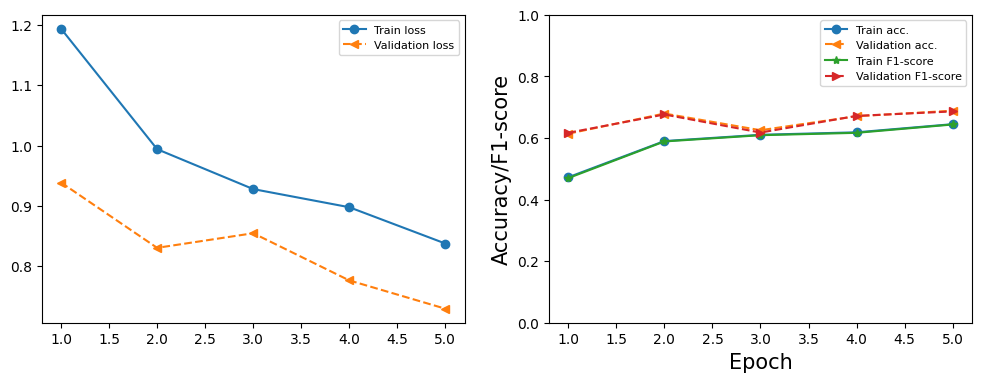

In [68]:
import matplotlib.pyplot as plt

def draw_metric_hist(metric_hist):
  
  # - Draw losses
  x_arr = np.arange(len(metric_hist["loss_train"])) + 1
  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 2, 1)
  ax.plot(x_arr, metric_hist["loss_train"], '-o', label='Train loss')
  ax.plot(x_arr, metric_hist["loss_val"], '--<', label='Validation loss')
    
  ax.legend(fontsize=8)
  ax = fig.add_subplot(1, 2, 2)
  
  # - Draw accuracy/f1score
  ax.set_ylim(0,1)  
  #plt.setp(ax, ylim=ax[0,0].get_ylim())  
  ax.plot(x_arr, metric_hist["acc_train"], '-o', label='Train acc.')
  ax.plot(x_arr, metric_hist["acc_val"], '--<', label='Validation acc.')
  ax.plot(x_arr, metric_hist["f1score_train"], '-*', label='Train F1-score')
  ax.plot(x_arr, metric_hist["f1score_val"], '-->', label='Validation F1-score')  
  ax.legend(fontsize=8)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Accuracy/F1-score', size=15)


  plt.show()  
    
logger.info("Plotting train run metrics ...")
draw_metric_hist(metric_hist)

## Test model
Let's load the saved trained model and run inference on test data. 

2025-03-08 17:31:45 INFO - Running inference on test data ...
2025-03-08 17:31:45 INFO - Loading model weights from file model_weights.pth ...
[Test]:   0%|                                                                                                                                                                              | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_1425898/3453250542.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cond= np.isfinite(img).bool()
2025-03-08 17:31:51 INFO - Drawing confusion matrix for test set ...                                                                                                                                               


--> metrics (TEST)
{'acc': 0.6809999942779541, 'avg_f1score': 0.6820935606956482, 'cm': array([[0.60157794, 0.15779093, 0.03550296, 0.20512821],
       [0.01976285, 0.6758893 , 0.256917  , 0.04743083],
       [0.02366864, 0.31360948, 0.5996055 , 0.06311637],
       [0.05416667, 0.03958333, 0.05      , 0.85625   ]], dtype=float32), 'cm_metric': MulticlassConfusionMatrix()}


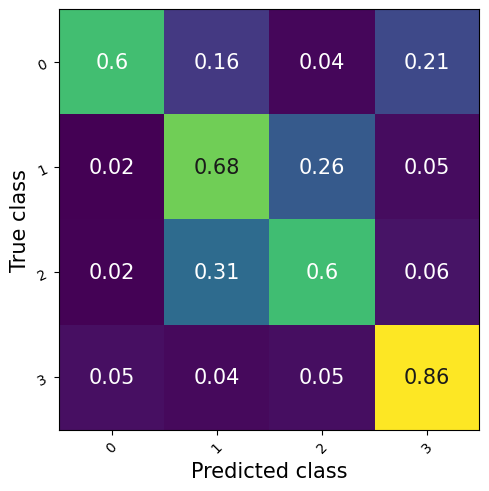

In [88]:
# - Run inference on test set
logger.info("Running inference on test data ...")
metrics_test= classifier.run_test(
  dataloader=dataloader_test,
  weightfile="model_weights.pth"  
)

print("--> metrics (TEST)")
print(metrics_test)

# - Draw confusion matrix
logger.info("Drawing confusion matrix for test set ...")
fig_, ax_ = metrics_test["cm_metric"].plot()